# Creating a audio pipeline for Urban Sounds

###  Goal of the notebook
This notebook is a pipeline for audio classification. With the notebook you can record an audio sample and do audio classification with CLAP.

### The Pipeline
1. Record an audio sample
2. Audio classification using CLAP general large model
3. Store the results (to do)

### Contents
0. Install packages & check versions
1. Take audio sample
2. Classify the sample
3. Store the sample and the result in a database


## 0. Install packages

In [ ]:
#!pip install pyaudio

In [2]:
#!pip install soundfile

In [3]:
#!pip install librosa

In [1]:
#!pip install datasets

In [4]:
#%pip install datasets\[audio\]

In [1]:
pip install numpy==1.26

Note: you may need to restart the kernel to use updated packages.


In [7]:
#check python version
import platform
print(platform.python_version())

#Check os version (uncomment if necessary)
print(platform.system())
#platform.linux_distribution()

3.12.2
Darwin


In [45]:
#basic python packages
import numpy as np
print(f'numpy={np.__version__}')
import IPython
print(f'ipython={IPython.__version__}')
import matplotlib as plt
print(f'matplotlib= {plt.__version__}')

numpy=1.26.0
ipython=8.27.0
matplotlib= 3.9.2


In [43]:
#audio packages
import soundfile
print(f'soundfile={soundfile.__version__}')
import librosa
print(f'librosa={librosa.__version__}')
import pyaudio
print(f'pyaudio= {pyaudio.__version__}')


soundfile=0.9.0
librosa=0.10.2.post1
pyaudio= 0.2.14


In [40]:
#deep learning packages
import torch
print(f'torch= {torch.__version__}')
import datasets
print(f'datasets={datasets.__version__}')
import transformers
print(f'transformers={transformers.__version__}')

torch= 2.2.2
datasets=3.1.0
transformers=4.48.3


## 1. Take audio sample and save it

In [ ]:

import pyaudio
import wave #python build in audio module
import datetime
import os

#set the filename based on current time
current_time = datetime.datetime.now()
WAVE_OUTPUT_FILENAME = current_time.strftime("%Y-%m-%d_%H-%M-%S") + ".wav"

# Audio recording parameters
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000
RECORD_SECONDS = 10

# Initialize PyAudio
audio = pyaudio.PyAudio()

# Open stream
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

print("Recording...")

frames = []

# Record for RECORD_SECONDS
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Recording finished.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()

# Save the recorded data as a WAV file

# Ensure the "samples" folder exists
os.makedirs("samples", exist_ok=True)

# Define the output filename with the "samples" folder
WAVE_OUTPUT_FILENAME = os.path.join("samples", WAVE_OUTPUT_FILENAME)

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(audio.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

print(f"Audio sample saved as {WAVE_OUTPUT_FILENAME}")


Recording...
Recording finished.
Audio sample saved as samples/2025-02-24_14-09-15.wav


In [11]:
import IPython
IPython.display.Audio(WAVE_OUTPUT_FILENAME)

## 2. Classify the audio sample


In [12]:
#Convert the recorded .wav file to a numpy array for use in CLAP
import soundfile as sf
import numpy as np
import IPython

# Path to the .wav file
wav_file_path = WAVE_OUTPUT_FILENAME
#wav_file_path = "./samples/2025-02-10_12-14-34.wav"  # Replace with your .wav file path

# Read the .wav file using soundfile
audio, samplerate = sf.read(wav_file_path)

# Display the NumPy array and sample rate
print(f"Audio data: {audio}")
print("Sample Rate:", samplerate)
IPython.display.Audio(audio, rate=48000)

Audio data: [0.         0.         0.         ... 0.02166748 0.01116943 0.0039978 ]
Sample Rate: 48000


In [13]:
# With the similarity search approach of CLAP we can now use a whole range of labels 
labels_list =['Gunshot', 'Alarm', 'Moped', 'Car', 'Motorcycle', 'Claxon', 'Slamming door', 'Screaming', 'Talking','Music', 'Birds', 'Airco', 'Noise', 'Silence']

print(labels_list)

['Gunshot', 'Alarm', 'Moped', 'Car', 'Motorcycle', 'Claxon', 'Slamming door', 'Screaming', 'Talking', 'Music', 'Birds', 'Airco', 'Noise', 'Silence']


In [31]:
#%%timeit
#larger_clap_general
from transformers import pipeline
import IPython

def audio_classfication(audio, labels_list):
    global output
    audio_classifier = pipeline(task="zero-shot-audio-classification", model="laion/larger_clap_general")
    output = audio_classifier(audio, candidate_labels=labels_list)
    return output

audio_classfication(audio, labels_list)
print(f'First result is {output[0]['label']}: {output[0]['score']}')
print(f'Second result is {output[1]['label']}: {output[1]['score']}')
print(f'Third result is {output[2]['label']}: {output[2]['score']}')
IPython.display.Audio(audio, rate=48000)

Device set to use cpu


First result is Moped: 0.5663310289382935
Second result is Car: 0.262673556804657
Third result is Motorcycle: 0.16916221380233765


## Some data analysis on the recorded sample

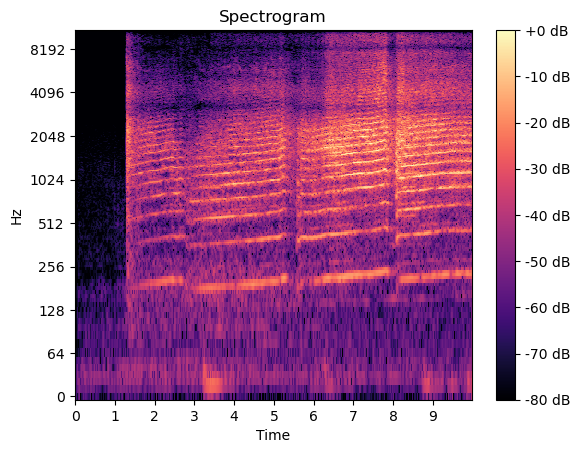

In [ ]:
#Create a spectrogram and show it
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

wav_file_path = WAVE_OUTPUT_FILENAME
#wavaudio = AudioSegment.from_wav(wavfile) 

y, sr = librosa.load(wav_file_path)
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure()
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()
#plt.savefig('samples/' + f"{filenr:0>{4}}" + 'c.png', transparent=False, dpi=80, bbox_inches="tight")


In [37]:
#Show numpy Peak-to-Peak
import numpy as np
import librosa

#load the sample with librosa
y, sr = librosa.load(wav_file_path)

# Calculate the peak-to-peak value
ptp_value = np.ptp(y)

print(f"Peak-to-peak value: {ptp_value}")

Peak-to-peak value: 0.4237941801548004


## Store in a .json file

In [15]:
#store the results in a .json file
import json

# Check if the results.json file exists
if os.path.exists('results.json'):
    # Load the existing JSON data
    with open('results.json', 'r') as f:
        results = json.load(f)
else:
    # If the file doesn't exist, start with an empty dict
    results = {}

# Define the new .wav file and its output
new_entry = {
    'filename': WAVE_OUTPUT_FILENAME,
    'result': output
}
# Add new_entry without overwriting existing keys
for key, value in new_entry.items():
    if key in results:
        # If the key exists, store the values as a list
        if not isinstance(results[key], list):
            results[key] = [results[key]]  # Convert to list if not already
        results[key].append(value)  # Append the new value
    else:
        results[key] = value  # Add new key-value pair

print(results)

# Save the updated results back to the JSON file
with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

{'filename': ['samples/2025-02-10_20-38-14.wav', 'samples/2025-02-10_20-38-14.wav', 'samples/2025-02-24_14-09-15.wav'], 'result': [{'score': 0.47123515605926514, 'label': 'Screaming'}, {'score': 0.4594155550003052, 'label': 'Silence'}, {'score': 0.04919607192277908, 'label': 'Airco'}, {'score': 0.006231608800590038, 'label': 'Claxon'}, {'score': 0.003251154674217105, 'label': 'Slamming door'}, {'score': 0.0030473489314317703, 'label': 'Talking'}, {'score': 0.0026044670958071947, 'label': 'Birds'}, {'score': 0.001197557314299047, 'label': 'Gunshot'}, {'score': 0.0011828267015516758, 'label': 'Car'}, {'score': 0.0008081781561486423, 'label': 'Motorcycle'}, {'score': 0.0007839786121621728, 'label': 'Moped'}, {'score': 0.0005850164452567697, 'label': 'Music'}, {'score': 0.00025111058494076133, 'label': 'Noise'}, {'score': 0.0002098860131809488, 'label': 'Alarm'}, [{'score': 0.47123515605926514, 'label': 'Screaming'}, {'score': 0.4594155550003052, 'label': 'Silence'}, {'score': 0.0491960719